In [1]:
import os
import glob
import pandas as pd
import lpips
import math
import plotly.express as px
import numpy as np
from natsort import natsorted
import cv2
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scipy.stats
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import lsqr
from itertools import product
from tqdm import tqdm
import glob
from openpyxl import Workbook
from openpyxl.drawing.image import Image as Image_openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.xdr import XDRPositiveSize2D
from openpyxl.utils.units import pixels_to_EMU, cm_to_EMU
from openpyxl.drawing.spreadsheet_drawing import OneCellAnchor, AnchorMarker
import pickle
import plotly.graph_objects as go

In [2]:
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_f = transforms.ToTensor()

def normalize_image(in_img):
    pixels = np.asarray(in_img).astype('float32')
    pixels = (pixels - mean) / std
    return pixels

In [4]:
images_dir = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/Images'
data_path = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data'
gt_fol = os.path.join(data_path, "GT_N")

In [5]:
def calculate_model_ap_ar_af1(gt_path, gt_files, pred_path, obj_list=None):
    gt_dict = {}
    pred_dict = {}

    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        gt_data.replace(-1, 1, inplace=True)
        x = []
        for index, row in gt_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in gt_dict.keys():
                gt_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                gt_dict[list(row)[0].strip().lower()] = list(row)[1:]

            x.append(len(list(row)[1:]))

        y = []
        pred_data = pd.read_csv(pred_fl)
        pred_data.replace(-1, 1, inplace=True)
        for index, row in pred_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in pred_dict.keys():
                pred_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                pred_dict[list(row)[0].strip().lower()] = list(row)[1:]
            y.append(len(list(row)[1:]))

        if x != y:
            print(len(x), len(y), fl)

    target_array = []
    pred_array = []

    label_names = []

    for key in gt_dict.keys():
        if key in pred_dict.keys():
            if obj_list:
                if key not in obj_list:
                    continue
            if len(gt_dict[key]) == len(pred_dict[key]):
                target_array.append(gt_dict[key])
                pred_array.append(pred_dict[key])
                label_names.append(key)
            else:
                print(len(gt_dict[key]), len(pred_dict[key]), key)
    
    target_array = np.array(target_array).T
    pred_array = np.array(pred_array).T

    # try:
    if pred_path.endswith('GT_N'):
        precs = precision_score(target_array, pred_array, average="micro")
        recs = recall_score(target_array, pred_array, average="micro")
        f1ss = f1_score(target_array, pred_array, average="micro")
    else:
        precs = precision_score(target_array, pred_array, average="micro")
        recs = recall_score(target_array, pred_array, average="micro")
        f1ss = f1_score(target_array, pred_array, average="micro")
    # except Exception as e:
    #     # ap = 0
    #     print(e)
    #     precs = 0.0
    #     recs = 0.0
    #     f1ss = 0.0

    return precs, recs, f1ss

In [6]:
def get_sim_score(img_dir, vid_n, seg_n):
    images = natsorted(glob.glob(
        os.path.join(
            images_dir,
            f'video-{vid_n}-segment-{seg_n}-frame*'
        )
    ))

    d_s = {}
    
    for f in range(1, len(images)):
        f_now_pth = images[f]
        f_prev_pth = images[f-1]

        frm0, frm1 = (os.path.basename(f_prev_pth).split('-')[-1].split('.')[0], 
                      os.path.basename(f_now_pth).split('-')[-1].split('.')[0])

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]

        d_s[f'{frm0}-{frm1}'] = d
    return d_s

In [7]:
coco_common_obj = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'traffic signals', 'fire hydrant', 'stop sign',
                   'bench', 'dog', 'chair', 'vegetation']

pfb_common_obj = ['road', 'sidewalk', 'tree', 'vegetation', 'building', 'fence', 'traffic signals',
                  'fire hydrant', 'chair', 'trash on roads', 'trash bins', 'person', 'car', 'motorcycle',
                  'bus']

ram_obj_map = {
    'chair': 'chair',
    'pillar': 'pillar',
    'table': 'table',
    'person': 'person',
    'man': 'person',
    'building': 'building',
    'city street': 'road',
    'curb': 'curb',
    'pavement': 'sidewalk',
    'road': 'road',
    'car': 'car',
    'snow': 'snow',
    'doorway': 'sloped driveway',
    'elevator': 'elevator',
    'rail': 'train tracks',
    'stair': 'stairs',
    'cane': 'white cane',
    'door': 'flush door',
    'fence': 'fence',
    'barrier': 'barrier post',
    'bench': 'bench',
    'sign': 'sign',
    'bin': 'trash bins',
    'pole': 'pole',
    'street vendor': 'street vendor',
    'blind': 'person with a disability',
    'dog': 'dog',
    'escalator': 'escalator',
    'street sign': 'sign post',
    'bus stop': 'bus stop',
    'railway station': 'train platform',
    'tree': 'tree',
    'traffic light': 'traffic signals',
    'tree trunk': 'tree',
    'recycling bin': 'trash bins',
    'train track': 'train tracks',
    'pedestrian': 'person',
    'bus': 'bus',
    'city bus': 'bus',
    'tour bus': 'bus',
    'wall': 'wall',
    'elevator door': 'elevator',
    'bicycle': 'bicycle',
    'crosswalk': 'crosswalk',
    'decker bus': 'bus',
    'motorcycle': 'motorcycle',
    'motorcyclist': 'person',
    'biker': 'person',
    'motorbike': 'motorcycle',
    'warning sign': 'sign',
    'hydrant': 'fire hydrant',
    'school bus': 'bus',
    'vegetation': 'vegetation',
    'fountain': 'fountain'
}

ram_com_obj = list(set(list(ram_obj_map.values())))
all_com = natsorted(list(set(ram_com_obj) & set(coco_common_obj) & set(pfb_common_obj)))
print(len(all_com))

8


In [8]:
gt_dir = gt_fol # "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GT_N"

gts = natsorted(os.listdir(gt_dir))

skip_list = [
    "video-10-segment-1.csv", "video-9-segment-2.csv"
]

gts = [x.split('.')[0] for x in gts if x.endswith('.csv') and int(x.split('-')[1])<=16 and x not in skip_list]

# gts = ['video-1-segment-4']

len(gts)

19

In [9]:
# all_sim_dict = {}

# for gt in gts:
#     v_ = int(gt.split('-')[1])
#     s_ = int(gt.split('-')[3])
#     sims = get_sim_score(images_dir, v_, s_)
#     all_sim_dict[gt] = sims

In [10]:
# import pickle

# with open('all_sims.pickle', 'wb') as handle:
#     pickle.dump(all_sim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
def laplace_smoothing(mat, alpha):
    N_t_s = mat.sum(axis=1)
    d_ps = N_t_s.shape[0]
    
    for ind, row in enumerate(mat):
        new_row = (row + alpha) * (N_t_s[ind] / (N_t_s[ind] + (alpha * d_ps)))
        new_row = new_row / (np.sum(new_row) + 1e-20)
        mat[ind] = new_row

    return mat

In [12]:
def get_transition_matrix(pred_file, objs):
    pred_df = pd.read_csv(pred_file)
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    act_st = []

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        transition_matrix[s_now][s_prev] += 1.0
        if f == 1:
            act_st.append(int(s_prev, 2))
            act_st.append(int(s_now, 2))
        else:
            act_st.append(int(s_now, 2))

    transition_matrix = np.array(transition_matrix)

    laplace_smoothing(transition_matrix, alpha=1e-3)

    for tr_ind, tm_row in enumerate(transition_matrix):
        if tm_row.sum() == 0.0:
            transition_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]
            
    return transition_matrix, act_st

In [13]:
def get_emission_matrix(gt_file, objs):
    gt_df = pd.read_csv(gt_file)
    gt_df = gt_df.transpose()
    gt_df.columns = gt_df.iloc[0]
    gt_df = gt_df.iloc[1:]
    gt_df.columns = map(str.lower, gt_df.columns)
    if objs is not None:
        gt_df = gt_df.reindex(columns=objs)

    gt_df = gt_df.fillna('0').transpose()

    all_states = []
    n_o_s = 2**(len(objs))

    for x in range(n_o_s):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        all_states.append(str_bit)

    emission_matrix_dict = {
        'st': [x for x in all_states]
    }
    for u_f, _ in enumerate(gt_df.columns):
        emission_matrix_dict[str(u_f)] = [0.0 for _ in all_states]

    emission_matrix = pd.DataFrame(emission_matrix_dict)
    emission_matrix = emission_matrix.set_index('st') 

    frame_state_dict = {}
    for col in gt_df.columns:
        frm_df = gt_df.reindex(columns=[col])
        c_state = "".join([str(x) for x in np.array(frm_df)[:, 0]])
        c_f = col.replace('_', '-').split('-')[-1]
        if c_state not in frame_state_dict.keys():
            frame_state_dict[c_state] = []
        frame_state_dict[c_state].append(c_f)

    for f_st in all_states:
        if f_st not in frame_state_dict.keys():
            prob_each = 1 / len(list(gt_df.columns))
            for f_f, _ in enumerate(gt_df.columns):
                emission_matrix[str(f_f)][f_st] = prob_each
        else:
            prob_each = 1 / len(frame_state_dict[f_st])
            for f_f in frame_state_dict[f_st]:
                emission_matrix[f_f][f_st] = prob_each

    emission_matrix = np.array(emission_matrix)

    emission_matrix = laplace_smoothing(emission_matrix, alpha=1e-5)

    return emission_matrix

In [14]:
def get_inital_prob_dist_and_obsrv_seq(pred_file, objs):
    pred_df = pd.read_csv(pred_file)
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    init_matrix_dict = {
        'st': ['init']
    }
    
    for u_s_s in unq_st_str:
        init_matrix_dict[u_s_s] = [0.0]

    init_matrix = pd.DataFrame(init_matrix_dict)
    init_matrix = init_matrix.set_index('st')

    
    s_init = ''.join([str(ch) for ch in pred[0]])
    init_matrix[s_init]['init'] += 1.0

    init_matrix = np.array(init_matrix)

    laplace_smoothing(init_matrix, alpha=1e-3)

    for tr_ind, tm_row in enumerate(init_matrix):
        if tm_row.sum() == 0.0:
            init_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]

    obsrv_seq = np.array([f for f in range(0, pred.shape[0])])        
            
    return init_matrix, obsrv_seq

In [53]:
def viterbi(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] * pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]

    x_T = np.argmax(V)
    max_P = V[x_T]

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]
    prev_ind = x_T

    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt, max_P


def viterbi_2(y, A, B, pi, x):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
        :param x: model heat map sequence 
    """
    current_prob = pi[0, x[0]] * B[x[0]][0]

    for j, x_ in enumerate(x[1:]):
        current_prob = current_prob * A[x[j]][x_] * B[x_][j+1]
        
    return x, current_prob

In [67]:
models = [
    'GT_N', 'BLIP', 'GPV-1', 'RAM', 'yolo_v7', 'HRNet_V2', 'mask_rcnn', 'faster_rcnn'
]

# models = [
#     'BLIP'
# ]

model_scores_dict = {}

for gt in gts[:1]:
    if gt not in model_scores_dict.keys():
        model_scores_dict[gt] = {}
    for model in models: 
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        gt_f = os.path.join(gt_fol, f'{gt}.csv')
        pred_f = os.path.join(
            data_path,
            f'{model}/video-{v_}-segment-{s_}.csv'
        )
        
        t_mat, actual_states = get_transition_matrix(pred_f, all_com)
        init_mat, o_seq = get_inital_prob_dist_and_obsrv_seq(pred_f, all_com)
        e_mat = get_emission_matrix(gt_f, all_com)

        # print(t_mat.shape, e_mat.shape, init_mat.shape)
    
        o_pth, pth_prob = viterbi(o_seq, t_mat, e_mat, init_mat)
        o_pth2, pth_prob2 = viterbi_2(o_seq, t_mat, e_mat, init_mat, actual_states)
        print(pth_prob)
        print(pth_prob2)
        print('-'*10)
        
        o_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth]
        a_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states]
        # print(o_pth, a_pth, o_pth==a_pth)

        p_, r_, f1_ = calculate_model_ap_ar_af1(
            gt_fol, [f'{gt}.csv'], os.path.join(data_path, model), 
            obj_list=all_com
        )

        model_scores_dict[gt][model] = {
            'ours': pth_prob2,
            'precision': p_,
            'recall': r_,
            'F1': f1_
        }
            

6.314486787237987e-34
6.3144867872379745e-34
----------
1.1893333513159275e-40
6.98859549843998e-45
----------
6.345474406369135e-38
2.860486355736493e-41
----------
1.0045178798057493e-37
1.004517879805749e-37
----------
2.5205662299897527e-39
1.1592785928074128e-41
----------
3.221672572892902e-40
4.5867623218843815e-51
----------
1.1295300880659772e-39
1.5057967274680006e-43
----------
1.406519980275195e-40
1.1979537796245612e-45
----------


In [57]:
select = 'F1'
model_scores_dict

{'video-1-segment-4': {'GT_N': {'ours': 6.3144867872379745e-34,
   'precision': 1.0,
   'recall': 1.0,
   'F1': 1.0},
  'BLIP': {'ours': 6.98859549843998e-45,
   'precision': 0.8571428571428571,
   'recall': 0.6461538461538462,
   'F1': 0.736842105263158},
  'GPV-1': {'ours': 2.860486355736493e-41,
   'precision': 0.9206349206349206,
   'recall': 0.8923076923076924,
   'F1': 0.90625},
  'RAM': {'ours': 1.004517879805749e-37,
   'precision': 1.0,
   'recall': 0.4,
   'F1': 0.5714285714285715},
  'yolo_v7': {'ours': 1.1592785928074128e-41,
   'precision': 1.0,
   'recall': 0.5692307692307692,
   'F1': 0.7254901960784313},
  'HRNet_V2': {'ours': 4.5867623218843815e-51,
   'precision': 0.7558139534883721,
   'recall': 1.0,
   'F1': 0.8609271523178808},
  'mask_rcnn': {'ours': 1.5057967274680006e-43,
   'precision': 0.7777777777777778,
   'recall': 0.6461538461538462,
   'F1': 0.7058823529411764},
  'faster_rcnn': {'ours': 1.1979537796245612e-45,
   'precision': 0.7241379310344828,
   'reca

In [58]:
print("-"*92)
for key in model_scores_dict:
    values = [model_scores_dict[key][mdl]['ours'] for mdl in model_scores_dict[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [list(model_scores_dict[key].keys())[vl] for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(92))
    print("-"*92)

--------------------------------------------------------------------------------------------
 video-1-segment-4: GT_N > RAM > GPV-1 > yolo_v7 > mask_rcnn > BLIP > faster_rcnn > HRNet_V2
--------------------------------------------------------------------------------------------
 video-1-segment-5: GT_N > BLIP > RAM > HRNet_V2 > mask_rcnn > yolo_v7 > GPV-1 > faster_rcnn
--------------------------------------------------------------------------------------------
 video-2-segment-1: GT_N > BLIP > mask_rcnn > GPV-1 > faster_rcnn > yolo_v7 > HRNet_V2 > RAM
--------------------------------------------------------------------------------------------
 video-3-segment-2: GT_N > RAM > HRNet_V2 > yolo_v7 > mask_rcnn > faster_rcnn > BLIP > GPV-1
--------------------------------------------------------------------------------------------
 video-3-segment-3: GT_N > mask_rcnn > BLIP > faster_rcnn > yolo_v7 > RAM > GPV-1 > HRNet_V2
----------------------------------------------------------------------

In [59]:
print("-"*92)
for key in model_scores_dict:
    values = [model_scores_dict[key][mdl][select] for mdl in model_scores_dict[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [list(model_scores_dict[key].keys())[vl] for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(92))
    print("-"*92)

--------------------------------------------------------------------------------------------
 video-1-segment-4: GT_N > GPV-1 > HRNet_V2 > BLIP > yolo_v7 > mask_rcnn > faster_rcnn > RAM
--------------------------------------------------------------------------------------------
 video-1-segment-5: GT_N > RAM > BLIP > yolo_v7 > GPV-1 > faster_rcnn > mask_rcnn > HRNet_V2
--------------------------------------------------------------------------------------------
 video-2-segment-1: GT_N > GPV-1 > BLIP > mask_rcnn > faster_rcnn > yolo_v7 > HRNet_V2 > RAM
--------------------------------------------------------------------------------------------
 video-3-segment-2: GT_N > yolo_v7 > RAM > GPV-1 > faster_rcnn > BLIP > mask_rcnn > HRNet_V2
--------------------------------------------------------------------------------------------
 video-3-segment-3: GT_N > BLIP > yolo_v7 > RAM > GPV-1 > HRNet_V2 > faster_rcnn > mask_rcnn
----------------------------------------------------------------------

In [60]:
import statistics
from scipy.stats import skew

normalized_likelihood = {
    'Model': [mdl for mdl in model_scores_dict[list(model_scores_dict.keys())[0]]]
}
f1_scores = {
    'Model': [mdl for mdl in model_scores_dict[list(model_scores_dict.keys())[0]]]
}

for key in model_scores_dict:
    vals = []
    mdls = []
    f1s = []
    for mdl in model_scores_dict[key]:
        mdls.append(mdl)
        vals.append(model_scores_dict[key][mdl]['ours'])
        f1s.append(model_scores_dict[key][mdl][select])

    vals = np.array(vals)
    # print(skew(vals, axis=0, bias=True))
    vals = np.log10(vals)
    # print(skew(vals, axis=0, bias=True))
    
    std = statistics.stdev(vals)
    mean = statistics.mean(vals)

    vals = ((vals-mean)/std) #/(2*std)) + 1 #+ 2 # [((ev-mean)/std)+1 for ev in vals]
    std2 = statistics.stdev(vals)
    vals = vals + (2*std2)
    # if np.min(vals) < 0:
    vals = vals + abs(np.min(vals))
    # skw = skew(vals, axis=0, bias=True)
    # if abs(skw) >= 0.5: 
    #     if skw > 0:
    #         vals = vals**(1/2)
    #     elif skw < 0:
    #         vals = vals**(2)
    # print(skew(vals, axis=0, bias=True))
    # print('-'*10)

    vals = vals/np.max(vals)
    
    normalized_likelihood[key] = vals 
    f1_scores[key] = f1s


In [61]:
normalized_likelihood_df = pd.DataFrame(normalized_likelihood)
normalized_likelihood_df.index = normalized_likelihood_df['Model'] 
normalized_likelihood_df = normalized_likelihood_df.drop(['Model'], axis=1)
normalized_likelihood_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in normalized_likelihood_df.columns]
normalized_likelihood_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
Model,,,,,,,,,,,,,,,,,,,
GT_N,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BLIP,0.470759,0.902134,0.718986,0.328375,0.604688,0.623180,0.773719,0.719963,0.818350,0.708267,0.785528,0.627421,0.788498,0.431975,0.578197,0.966071,0.708163,0.648327,0.952895
GPV-1,0.645244,0.447460,0.642073,0.216563,0.445393,0.786169,0.613612,0.398305,0.442232,0.364356,0.941925,0.343203,0.608932,0.651348,0.491588,0.893779,0.946390,0.587206,0.953005
RAM,0.816514,0.750102,0.110241,0.804648,0.460193,0.000000,0.308607,0.328070,0.536426,0.722217,0.614289,0.863228,0.183769,0.071045,0.193749,0.000000,0.130175,0.611994,0.998057
yolo_v7,0.626295,0.484258,0.601859,0.638896,0.512561,0.380534,0.334922,0.508337,0.787739,0.864752,0.342759,0.705384,0.290406,0.905594,0.369651,0.867522,0.296784,0.497355,0.000000
HRNet_V2,0.172087,0.635265,0.324939,0.728022,0.401505,0.730941,0.515271,0.487387,0.433650,0.214402,0.207730,0.779535,0.679632,0.585161,0.606671,0.787561,0.944682,0.451642,0.889650
mask_rcnn,0.535169,0.514884,0.702914,0.603003,0.640179,0.736645,0.637191,0.679243,0.678123,0.547009,0.603038,0.456748,0.774725,0.534471,0.638867,0.877624,0.875545,0.279345,0.801213
faster_rcnn,0.433759,0.340845,0.624456,0.563163,0.563756,0.723702,0.745580,0.587767,0.245306,0.549898,0.852669,0.381617,0.782495,0.704951,0.696745,0.952388,0.870299,0.434774,0.880233


In [62]:
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.index = f1_scores_df['Model'] 
f1_scores_df = f1_scores_df.drop(['Model'], axis=1)
f1_scores_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in f1_scores_df.columns]
f1_scores_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
Model,,,,,,,,,,,,,,,,,,,
GT_N,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BLIP,0.736842,0.933333,0.746154,0.813559,0.878049,0.891892,0.714286,0.880000,0.867925,0.727273,0.857143,0.721649,0.873786,0.893617,0.858824,0.898876,0.681818,0.967742,0.582278
GPV-1,0.906250,0.666667,0.789916,0.888889,0.772201,0.684932,0.827586,0.724324,0.567901,0.727273,0.828571,0.686275,0.678571,0.838235,0.880952,0.879121,0.800000,0.829787,0.850000
RAM,0.571429,0.976744,0.560000,0.913043,0.832536,0.600000,0.634921,0.781457,0.956522,0.173913,0.476190,0.972222,0.602740,0.200000,0.578125,0.545455,0.500000,0.732394,0.421053
yolo_v7,0.725490,0.869565,0.733333,0.979592,0.859813,0.852459,0.696970,0.858896,0.978723,0.975610,0.821429,0.944444,0.804348,0.736842,0.864198,0.805970,0.666667,0.839506,0.695652
HRNet_V2,0.860927,0.525000,0.672515,0.694444,0.751634,0.708333,0.759259,0.674330,0.433962,0.646154,0.731707,0.629630,0.627737,0.855346,0.851485,0.808081,0.736842,0.937500,0.840000
mask_rcnn,0.705882,0.579710,0.741007,0.754098,0.677741,0.710526,0.817204,0.720721,0.793103,0.823529,0.739726,0.546875,0.619048,0.787879,0.808989,0.691358,0.612245,0.833333,0.776471
faster_rcnn,0.682927,0.656250,0.736842,0.842105,0.710801,0.746667,0.831461,0.738739,0.779661,0.869565,0.779221,0.578512,0.639344,0.737589,0.784946,0.674699,0.549020,0.845361,0.755556


In [63]:
normalized_likelihood_df.columns

Index(['V1S4', 'V1S5', 'V2S1', 'V3S2', 'V3S3', 'V4S1', 'V4S3', 'V4S4', 'V5S1',
       'V6S2', 'V7S2', 'V8S2', 'V11S1', 'V12S4', 'V13S2', 'V14S1', 'V14S4',
       'V15S3', 'V16S3'],
      dtype='object')

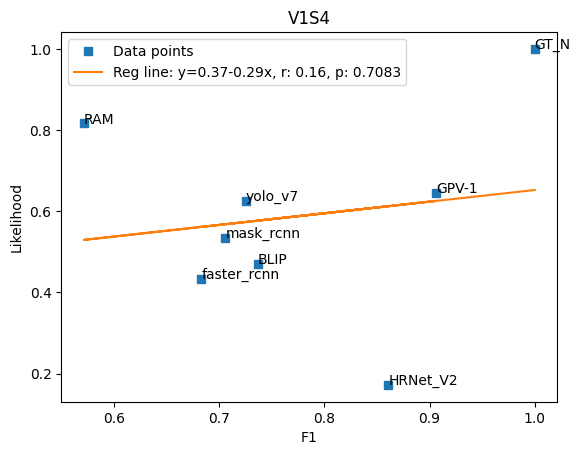

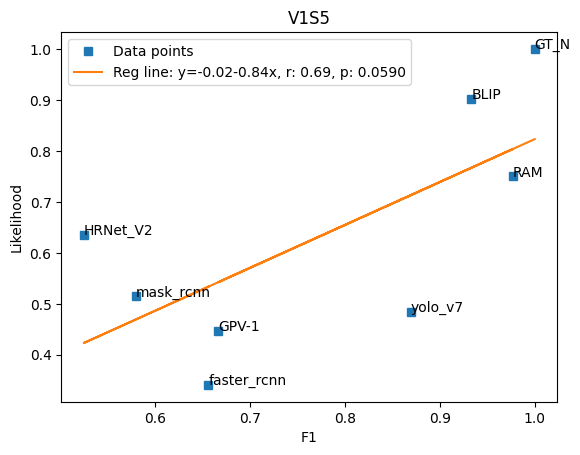

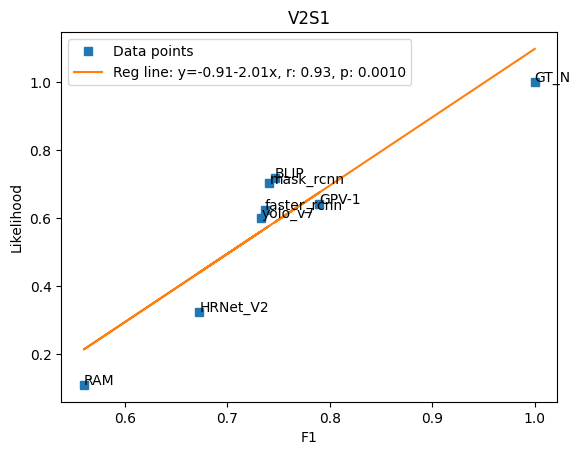

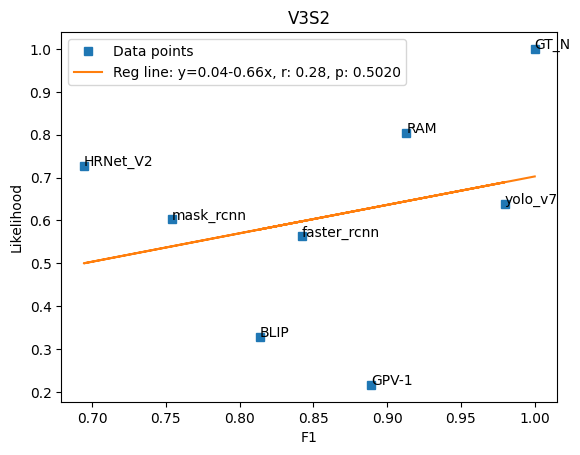

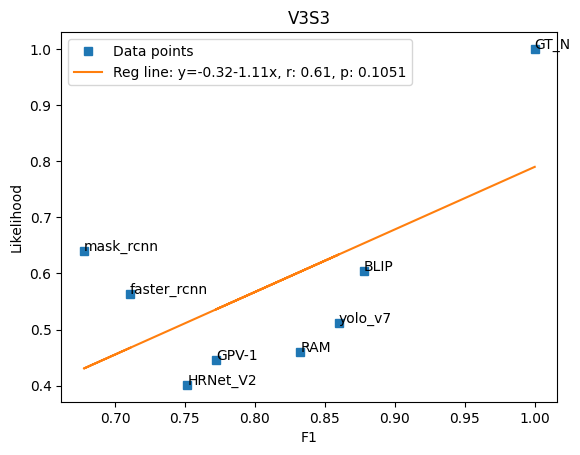

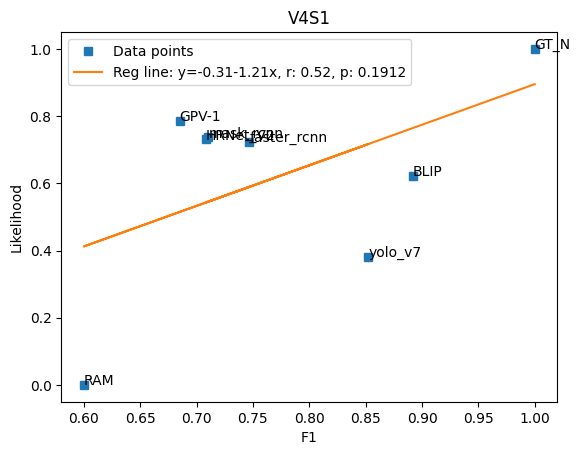

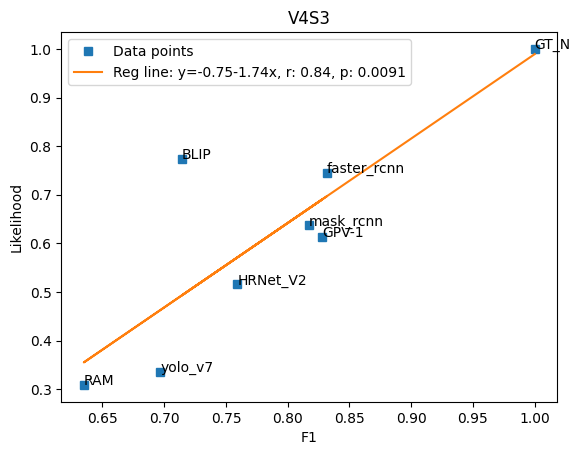

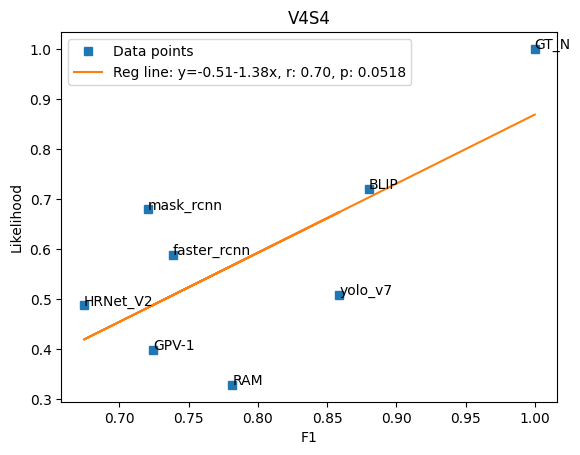

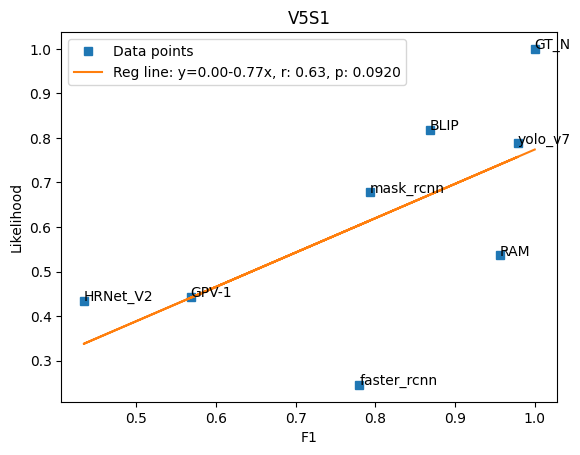

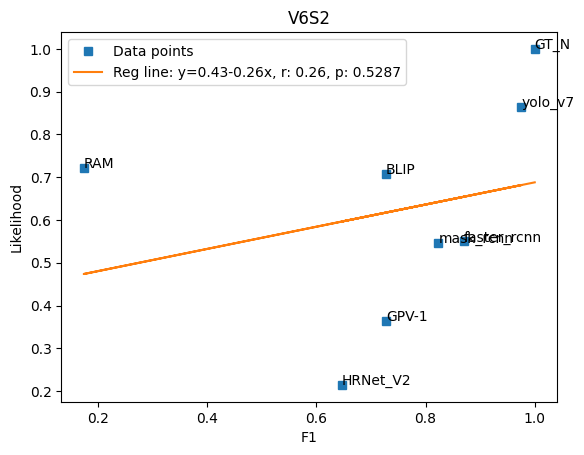

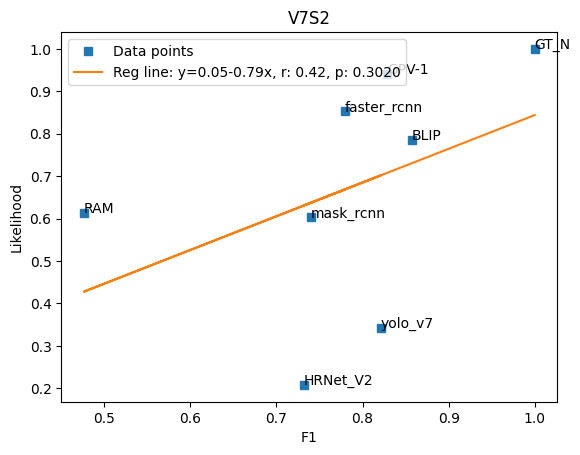

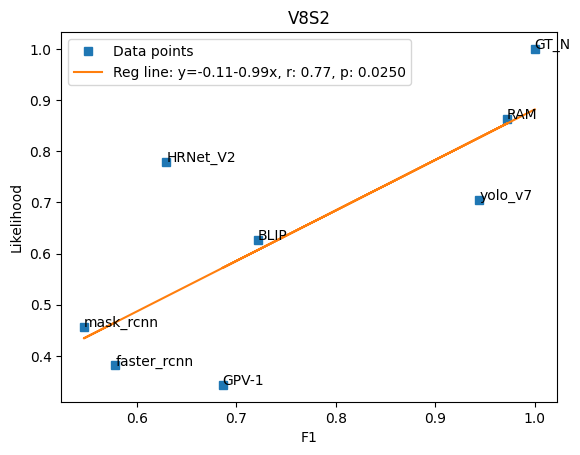

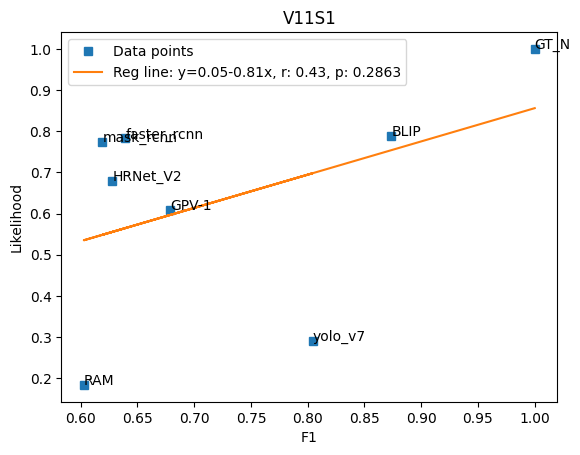

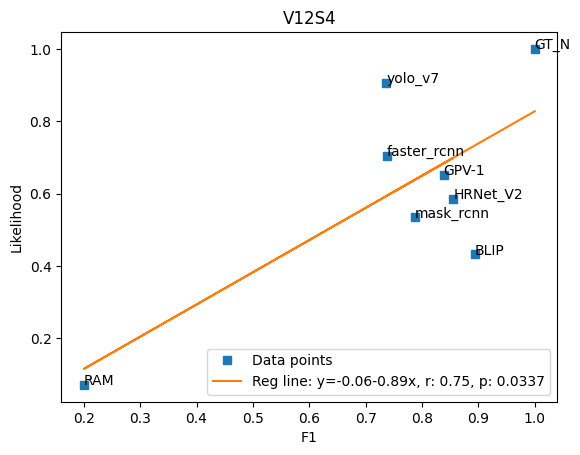

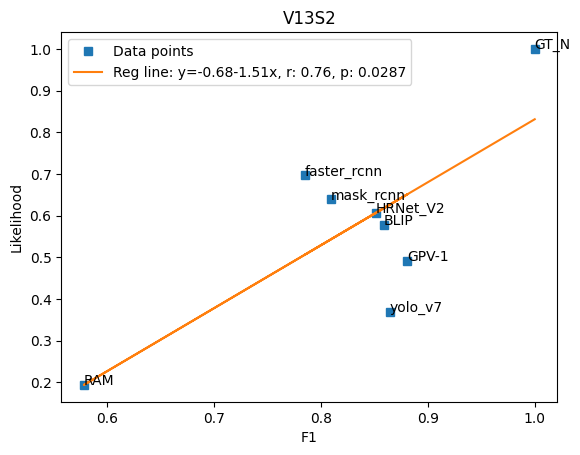

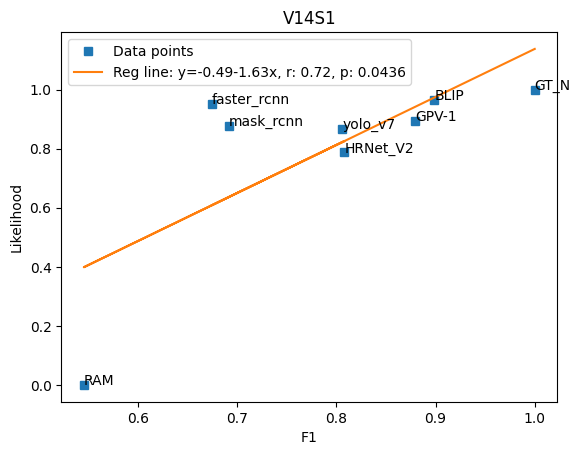

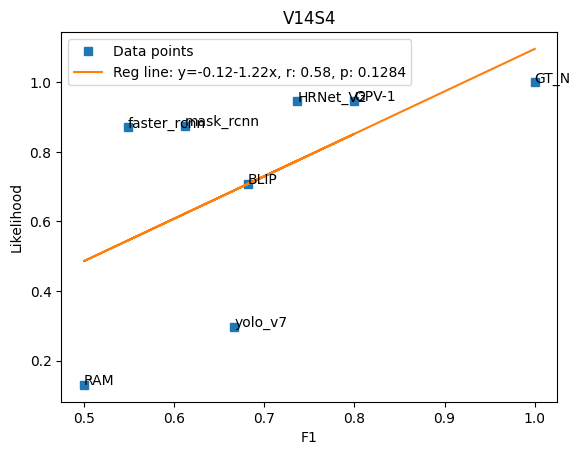

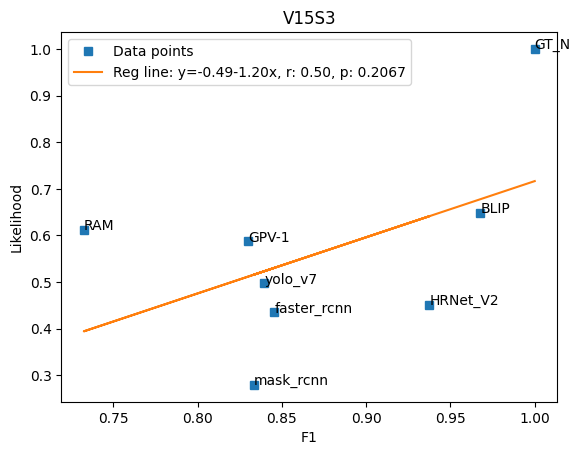

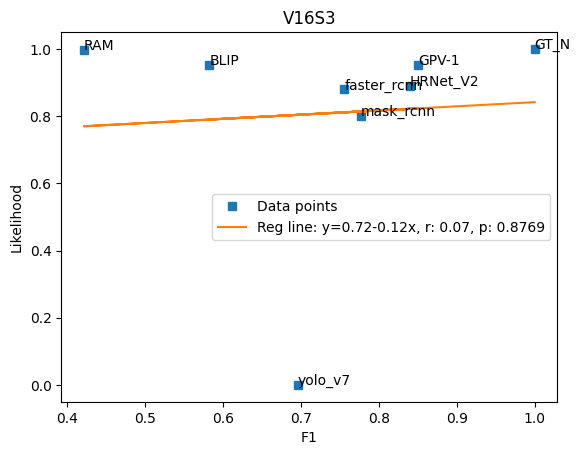

In [64]:
lklhd = {}
v_s_s = [
    'V1S4', 'V1S5', 'V2S1', 'V3S2', 'V3S3', 'V4S1', 'V4S3', 'V4S4', 'V5S1',
    'V6S2', 'V7S2', 'V8S2', 'V11S1', 'V12S4', 'V13S2', 'V14S1', 'V14S4',
    'V15S3', 'V16S3'
]

for v_s__ in v_s_s:
    v_s_ = [v_s__]
    for key in dict(normalized_likelihood_df.mean(axis='columns')):
        if key in ['GT_N (without lpips)']: # , 'GT_N (with lpips)'
            continue
        lklhd[key] = dict(normalized_likelihood_df.reindex(columns=v_s_).mean(axis='columns'))[key]
    
    mF1 = {}
    
    for key in dict(f1_scores_df.mean(axis='columns')):
        if key in ['GT_N (without lpips)']: # , 'GT_N (with lpips)'
            continue
        mF1[key] = dict(f1_scores_df.reindex(columns=v_s_).mean(axis='columns'))[key]
    
    x, y = np.array(list(mF1.values())), np.array(list(lklhd.values()))
    # print("pearson: ", scipy.stats.pearsonr(x, y))
    # print("spearman: ", scipy.stats.spearmanr(x, y))
    # print("kendall: ", scipy.stats.kendalltau(x, y))
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    line = f'Reg line: y={intercept:.2f}-{abs(slope):.2f}x, r: {r:.2f}, p: {p:.4f}'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='s', label='Data points')
    for i, txt in enumerate(mF1.keys()):
        ax.annotate(txt, (x[i], y[i]))
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel(f'{select}')
    ax.set_ylabel('Likelihood')
    ax.legend(facecolor='white')
    # plt.xlim(0.18, 0.7)
    # plt.ylim(0.36, 0.55)
    plt.title(f"{v_s_[0]}")
    plt.savefig(f'/Users/imrankabir/Desktop/corr_plots_vtrbi/{v_s__}.png')

In [65]:
def gen_heat_map(gt_path, gt_files, pred_path, obj_list=None, d_s=[]):
    hm_figs = []
    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        gt_data.replace(-1, 1, inplace=True)

        gt_data = gt_data.transpose()
        gt_data.columns = gt_data.iloc[0]
        gt_data = gt_data.iloc[1:]
        gt_data.columns = gt_data.columns.str.lower()
        if obj_list is not None:
            gt_data = gt_data.reindex(columns=obj_list)
    
        gt_data = gt_data.fillna('0').transpose()
        gt_data.columns = gt_data.columns.str.replace("_", "-")
        gt_data.columns = gt_data.columns.str.capitalize()

        pred_data = pd.read_csv(pred_fl)
        pred_data.replace(-1, 1, inplace=True)

        pred_data = pred_data.transpose()
        pred_data.columns = pred_data.iloc[0]
        pred_data = pred_data.iloc[1:]
        pred_data.columns = pred_data.columns.str.lower()
        if obj_list is not None:
            pred_data = pred_data.reindex(columns=obj_list)
    
        pred_data = pred_data.fillna('0').transpose()
        pred_data.columns = pred_data.columns.str.replace("_", "-")
        pred_data.columns = pred_data.columns.str.capitalize()

        hm_ = gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

        color_tp = 'rgb(71, 137, 209)' 
        color_tn = 'rgb(104, 212, 202)'
        color_fp = 'rgb(202, 121, 59)' 
        color_fn = 'rgb(198, 59, 59)'
        
        fig = go.Figure()
        
        colorscale = [
            [0, color_fp],
            [0.25, color_tn],
            [0.5, color_tp],
            [1, color_fn]
        ]
        
        fig.update_layout(
            template="simple_white",
            xaxis=dict(title_text="Frames", tickmode='linear'),
            yaxis=dict(title_text="Objects",  tickmode='linear'),
            width=1000,
            height=250,
            margin=dict(l=0, r=0, t=10, b=5),
            title=dict(
                text="",
                font=dict(size=16, color="black"),
                x=0.5,
                y=0.995
        
            )
        )
        
        fig.add_trace(
            go.Heatmap(
                z=hm_,
                x=[f'{i} {d_s[i]:.2f}' for i, x in enumerate(list(hm_.columns))],
                y=[x.capitalize() for i, x in enumerate(list(hm_.index))],
                colorscale=colorscale,
                zmin=-1,
                zmax=2
            )
        )


        # fig.add_traces(go.Bar(x=[], y =[], name='TP',
        #                  marker_color=color_tp))
        # fig.add_traces(go.Bar(x=[], y =[], name='FP',
        #                  marker_color=color_fp))
        # fig.add_traces(go.Bar(x=[], y =[], name='TN',
        #                  marker_color=color_tn))
        # fig.add_traces(go.Bar(x=[], y =[], name='FN',
        #                  marker_color=color_fn))
        
        fig.update_layout(
            font_family="Courier New, monospace",
            font_color="black",
            title_font_family="Courier New, monospace",
            title_font_color="black",
            legend_title_font_color="black",
            font=dict(size=14),
        )

        fig.update_traces(
          colorbar_tickmode='array',
          colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
          colorbar_tickvals=[-1, 0, 1, 2],
          colorbar_tickangle=0,
          selector=dict(type='heatmap')
         )

        fig.update_xaxes(ticklabelposition='outside')
        
        fig.update_xaxes(
            tickson="boundaries",
            ticklen=5,
            tickangle=90
        )
        fig.update_layout(
             xaxis=dict(showgrid=True),
             yaxis=dict(showgrid=True)
        )
        
        fig.update_layout(xaxis=dict(domain=[0, 1]))
        
        hm_figs.append(fig)

    return hm_figs

In [273]:
out_plot_path = './heat_maps_viterbi'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet = workbook.active

row = 2

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

for mod_ind, model_ in enumerate(models):
    col = 2
    worksheet.row_dimensions[row].height = 195
    worksheet.cell(row=row, column=1).value = model_
    worksheet.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

    for gt in gts:    
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        
        if mod_ind == 0:
            worksheet.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
            worksheet.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
            
        f1_s_xl = f1_scores_df[f'V{v_}S{s_}'][model_]
        lh_s_xl = normalized_likelihood_df[f'V{v_}S{s_}'][model_]

        d_i_s = [0] + list(sim_dict_pkl[gt].values())

        hm_p = gen_heat_map(
            gt_fol, [f'{gt}.csv'], os.path.join(data_path, model_), 
            obj_list=all_com, d_s=d_i_s
        )[0]
        hm_p.update_layout(
            title=dict(text=f"F1={f1_s_xl:.2f}, likelihood={lh_s_xl:.2f}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_out_name = os.path.join(out_plot_path, f'{model_}_v{v_}s{s_}_F1_{f1_s_xl:.2f}_likelihood_{lh_s_xl:.2f}.png')

        hm_p.write_image(
            img_out_name,
            format='png'
        )

        worksheet.column_dimensions[get_column_letter(col)].width = 128

        anchor = f'{get_column_letter(col)}{row}'
        # worksheet.add_image(Image_openpyxl(img_out_name), anchor=anchor)
        img = Image_openpyxl(img_out_name) 

        worksheet.add_image(img, anchor=anchor)
    
        col = col + 1
        
    row = row + 1

workbook.save('investigate_entropy_viterbi.xlsx')

9e-323

In [201]:
import sys
import numpy as np

# Example 1: Find maximum float value 
# Using sys.float_info
max_float_value = sys.float_info.max
min_float_value = sys.float_info.min


In [202]:
max_float_value, min_float_value

(1.7976931348623157e+308, 2.2250738585072014e-308)